In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tiling_disk_plots import full_hexagon_plot, coordinates_plot, z_value_hist
from tiling_disk_utils import read_coords, read_measurement, hex_table, point_table

First steps the project. Starting point of analysis. Now just interesting for historical purpose :)

# Not usable anymore

In [2]:
from os import walk
from pathlib import Path
filenames = next(walk(Path('.')), (None, None, []))[2]  # [] if no file
txts = {file: read_measurement(file) for file in filenames if file.endswith('.txt')}
files_coordinates = [f for f in txts if f.startswith('coordinate')]
files_disc1 = [f for f in txts if f.startswith('disc1')]
files_tile1 = [f for f in txts if f.startswith('tile1')];
#dfs_tile1 = {file: read_measurement(file) for file in files_tile1}
#dfs_disc1 = {file: read_measurement(file) for file in files_disc1}

In [3]:
one_tile_txts = {f: read_measurement(f) for f in txts if f.startswith('MyScan')}
txts.keys()

dict_keys(['cnc-error.txt', 'coordinate-bottom.txt', 'coordinate-discbroken-bottom.txt', 'coordinate-discbroken-top.txt', 'coordinate-tile1.txt', 'coordinate-top.txt', 'disc1-broken-bottom.txt', 'disc1-broken-top.txt', 'hexagon-position.txt', 'MyScan_Test_1Tile.txt', 'MyScan_Test_1Tile_LAO1_noVac.txt', 'MyScan_Test_1Tile_LAO1_Vac.txt', 'MyScan_Test_1Tile_LAO1_Vac_pol.txt', 'Notes.txt', 'tile1-cnc.txt', 'tile1-lao1.txt', 'tile1-steel-sandblasted.txt', 'tile1-steel.txt'])

In [4]:
cord_top_df = txts['coordinate-bottom.txt']

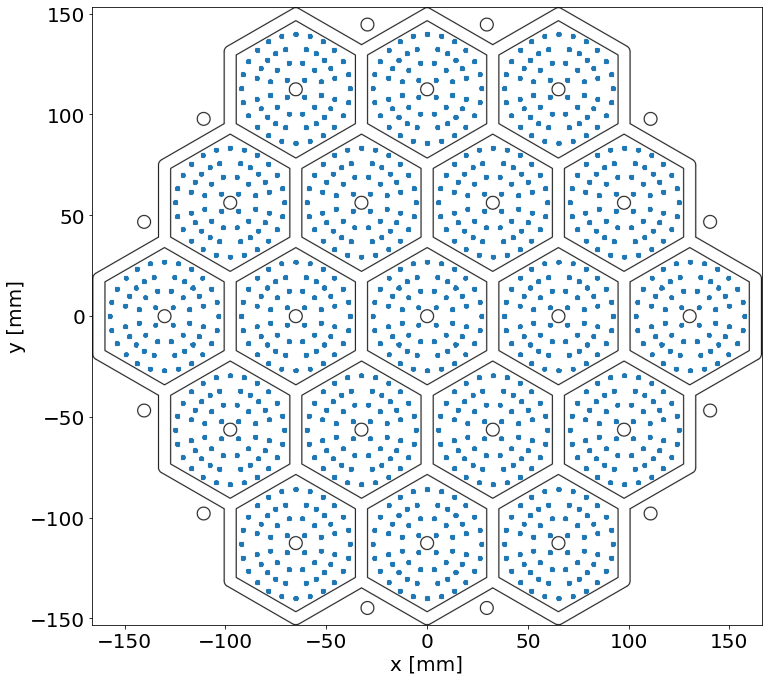

In [5]:
cord_top_df = txts['coordinate-bottom.txt']
coordinates_plot(cord_top_df)

## Disk Broken

In [33]:
%matplotlib 
dfs_disc1 = [read_measurement(f) for f in files_disc1]
for (index, measurement_df) in enumerate(dfs_disc1):
    fig,ax = full_hexagon_plot(measurement_df, hexagon_origin=True, hexgrid=True, size=10)
    ax.set_title(files_disc1[index], fontsize=20)
    

Using matplotlib backend: Qt5Agg


In [7]:
hex_table_d1 = hex_table(dfs_disc1[1])
fig, ax = full_hexagon_plot(hex_table_d1, mode=('z','median'), hexgrid=True, size=120**2, marker='h')
ax.set_title("median", fontsize=20)

Text(0.5, 1.0, 'median')

## Cnc Error analysis

In [8]:
cnc_df = txts['cnc-error.txt']

### Per Hexagon

In [9]:
hex_cnc_table = hex_table(cnc_df)

full_hexagon_plot(hex_cnc_table, mode=('z','mean'), hexgrid=True, size=120**2, marker='h')
ax.set_title("mean", fontsize=20)
plt.close()

### Per points

In [10]:
point_table_cnc = pd.pivot_table(cnc_df, values=['x','y','z'], index=['hex_nr', 'point'],
                        aggfunc={
                            'x': np.mean,
                            'y': np.mean,
                            'z': [np.mean,np.median,np.std],})
fig, ax = full_hexagon_plot(point_table_cnc, mode=('z','mean'), hexgrid=True, size=8**2, marker='o')
ax.set_title("median", fontsize=20)

Text(0.5, 1.0, 'median')

In [11]:
# z_value_hist(point_table)

# Steel Scan

In [12]:
one_tile_scans_path = Path('.') / 'one_tile_scan'
one_tile_files = next(walk(one_tile_scans_path), (None, None, []))[2]  # [] if no file

steelscan_files = {file: read_measurement(one_tile_scans_path/file) for file in one_tile_files if file.startswith('SteelScan')}

In [13]:
steelscan_files.keys()

dict_keys(['SteelScan_notiles.txt', 'SteelScan_points_down.txt', 'SteelScan_points_up.txt'])

In [14]:
#? Correct the data by applying laser distance correction
correction_term =  {'notiles':158.26, 'down': 157.23, 'up': 157.29}
for (mode, c_term), (run, data) in zip(correction_term.items(), steelscan_files.items()):
    print(mode)
    print(run)
    data['z'] = data['z'].apply(lambda x: x+c_term)

notiles
SteelScan_notiles.txt
down
SteelScan_points_down.txt
up
SteelScan_points_up.txt


In [15]:
steelscan_pivot = {name: point_table(data) for (name, data) in steelscan_files.items()}

## Fitting full plate 

In [16]:
from sklearn.linear_model import LinearRegression
from matplotlib.colors import TwoSlopeNorm

notiles_pt = steelscan_pivot['SteelScan_notiles.txt']

xy_vec = [[x,y] for (x,y) in zip(notiles_pt['x', 'mean'], notiles_pt['y', 'mean'])]
xy_vec = np.array(xy_vec)
z_vec = np.array(notiles_pt['z', 'median'])

model = LinearRegression().fit(xy_vec, z_vec)
r_sq = model.score(xy_vec,z_vec)
z_0 = model.intercept_
slope = model.coef_
F = r_sq/2 * len(notiles_pt['z', 'median'])
z_pred = z_pred = model.predict(xy_vec)
z_corrected = notiles_pt['z', 'median'].apply(lambda x: x-z_0)
z_pred = [z - z_0 for z in z_pred]
# chi_sq = my_chi_square(z_corrected, np.asarray(z_pred), notiles_pt['z', 'std']) / 3
chi_sq = 42
z_pred = np.array(z_pred)


model_params = {'r_sq': r_sq, 'z_0': z_0, 'slope': slope, 'F': F, 'chi_sq': chi_sq}
for key, val in model_params.items():
    print(f'{key} = {val}')
    
#* Plot surface + points 
%matplotlib
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.hold(True)
xx, yy = np.meshgrid(notiles_pt['x', 'mean'], notiles_pt['y', 'mean'])
cbar_max = 100
cbar_min = -50
colornorm = TwoSlopeNorm(vcenter=0, vmax=cbar_max, vmin=cbar_min) 
surface = ax.plot_trisurf(notiles_pt['x', 'mean'], notiles_pt['y', 'mean'], z_pred*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar = fig.colorbar(surface)
ax.scatter(notiles_pt['x', 'mean'], notiles_pt['y', 'mean'], z_corrected*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar.ax.tick_params(labelsize=16)
c_bar.ax.set_ylabel("height [$\mu$m]", fontsize=16)
ax.set_xlabel("x [mm]", fontsize=16)
ax.set_ylabel("y [mm]", fontsize=16)
ax.set_zlabel("z [$\mu$m]", fontsize=16)
ax.tick_params(labelsize=16)

r_sq = 0.6802791073492122
z_0 = 158.25146140350876
slope = [-0.00023499  0.00030624]
F = 387.75909118905093
chi_sq = 42
Using matplotlib backend: Qt5Agg


(<Figure size 720x288 with 2 Axes>,
 (<AxesSubplot:xlabel='$\\overline{z}$ [$\\mu$m]', ylabel='counts'>,
  <AxesSubplot:xlabel='z - std [$\\mu$m]', ylabel='counts'>))

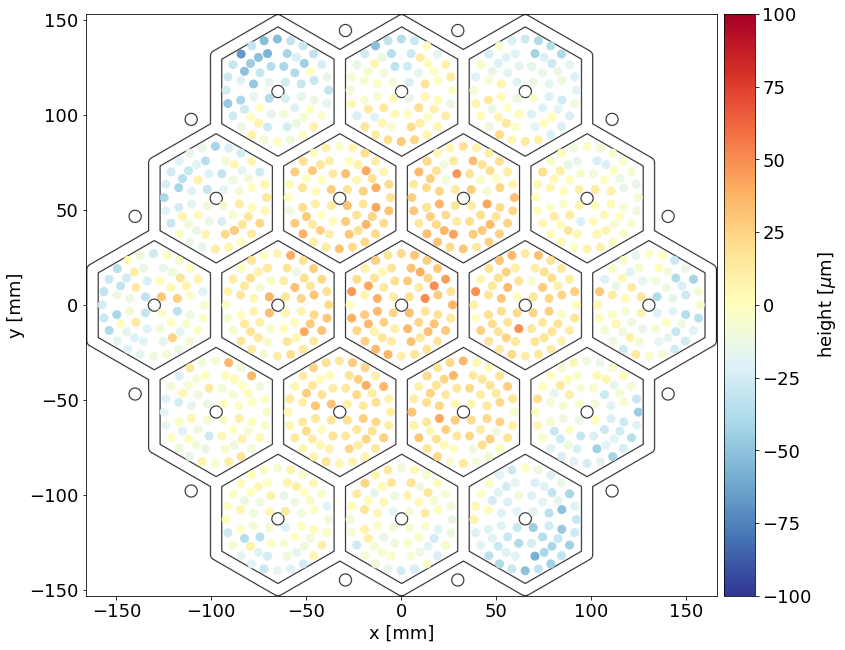

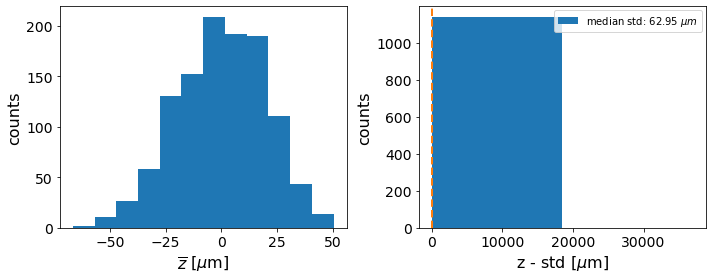

In [17]:
notiles_pt['z', 'median'] = z_corrected
notiles_pt['z', 'median'] = notiles_pt['z', 'median'] - z_pred
%matplotlib inline
full_hexagon_plot(notiles_pt, mode=('z','median'), size=8**2)
z_value_hist(notiles_pt, nbin_std=2)

## Fitting plane by hexagon

In [18]:
# from sklearn.linear_model import LinearRegression
# fit = {}
# for i in range(1,20):
#     hexagon_df = test_df_2.query(f'hex_nr == {i}')

#     xy_vec = [[x,y] for (x,y) in zip(hexagon_df['x', 'mean'], hexagon_df['y', 'mean'])]
#     xy_vec = np.array(xy_vec)
#     z_vec = np.array(hexagon_df['z', 'median'])

#     model = LinearRegression().fit(xy_vec, z_vec)
#     r_sq = model.score(xy_vec,z_vec)
#     z_0 = model.intercept_
#     slope = model.coef_
#     F = r_sq/2 * len(hexagon_df['z', 'median'])
#     z_pred = z_pred = model.predict(xy_vec)
#     z_corrected = hexagon_df['z', 'median'].apply(lambda x: x-z_0)
#     z_pred = [z - z_0 for z in z_pred]
#     chi_sq = my_chi_square(z_corrected, np.asarray(z_pred), hexagon_df['z', 'std']) / 3
#     z_pred = np.array(z_pred)


#     model_params = {'r_sq': r_sq, 'z_0': z_0, 'slope': slope, 'F': F, 'chi_sq': chi_sq}
#     for key, val in model_params.items():
#         print(f'{key} = {val}')
#     fit[f'hexagon_{i}'] = {'params': model_params,
#                           'z_c': z_corrected,
#                            'coords': [hexagon_df['x', 'mean'], hexagon_df['x', 'mean']]}


https://realpython.com/linear-regression-in-python/ top ding

In [19]:
# #* Plot surface + points 
# %matplotlib
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# # plt.hold(True)
# xx, yy = np.meshgrid(notiles_pt['x', 'mean'], notiles_pt['y', 'mean'])
# cbar_max = 100
# cbar_min = -50
# colornorm = TwoSlopeNorm(vcenter=0, vmax=cbar_max, vmin=cbar_min) 
# surface = ax.plot_trisurf(notiles_pt['x', 'mean'], notiles_pt['y', 'mean'], z_pred*1e3, cmap="RdYlBu_r", norm=colornorm)
# c_bar = fig.colorbar(surface)
# ax.scatter(notiles_pt['x', 'mean'], notiles_pt['y', 'mean'], z_corrected*1e3, cmap="RdYlBu_r", norm=colornorm)
# c_bar.ax.tick_params(labelsize=16)
# c_bar.ax.set_ylabel("height [$\mu$m]", fontsize=16)
# ax.set_xlabel("x [mm]", fontsize=16)
# ax.set_ylabel("y [mm]", fontsize=16)
# ax.set_zlabel("z [$\mu$m]", fontsize=16)
# ax.tick_params(labelsize=16)

# One Tile txt

## One Tile Scan w/o offset

In [20]:
one_tile_scans_path = Path('.') / 'one_tile_scan'
one_tile_files = next(walk(one_tile_scans_path), (None, None, []))[2]  # [] if no file

one_tile_scans = {file: read_measurement(one_tile_scans_path/file) for file in one_tile_files if file.startswith('070921')}
one_tile_scans_pt = {key: point_table(data) for key,data in one_tile_scans.items()}
one_tile_ref = one_tile_scans_pt['070921_1Tile_empty.txt']

### Vac vs NO Vac

(<Figure size 720x288 with 2 Axes>,
 (<AxesSubplot:xlabel='$\\overline{z}$ [$\\mu$m]', ylabel='counts'>,
  <AxesSubplot:xlabel='z - std [$\\mu$m]', ylabel='counts'>))

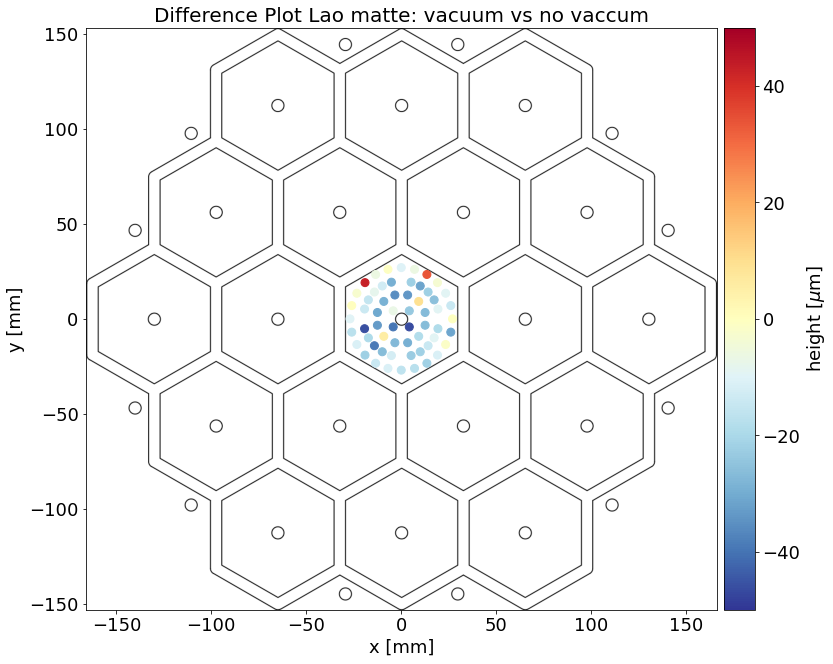

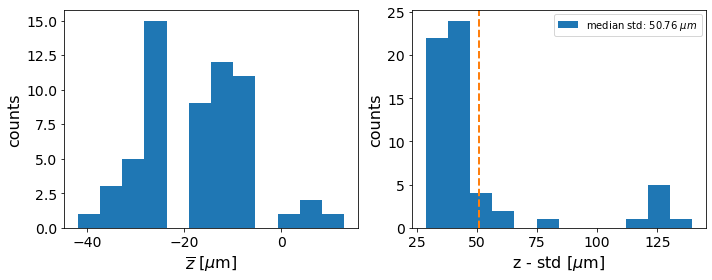

In [21]:
%matplotlib inline
vac = one_tile_scans_pt['070921_1Tile_LAO_Vac_matt.txt']
no_vac = one_tile_scans_pt['070921_1Tile_LAO_noVac_matt.txt']

diff_vac_novac = vac - no_vac

diff_vac_novac['x', 'mean'] = vac['x', 'mean']
diff_vac_novac['y', 'mean'] = vac['y', 'mean']
diff_vac_novac['z', 'std'] = np.sqrt(np.add(np.power(vac['z', 'std'],2),np.power(no_vac['z', 'std'],2)))

diff_vac_novac
fig, ax = full_hexagon_plot(diff_vac_novac, mode=('z', 'mean'),size=8**2, cbar_max=50, cbar_min=-50)
ax.set_title('Difference Plot Lao matte: vacuum vs no vaccum', fontsize=20)
z_value_hist(diff_vac_novac)

In [22]:
import statsmodels.formula.api as sm 
from sklearn.preprocessing import PolynomialFeatures

from matplotlib.colors import TwoSlopeNorm

xy_vec = [[x,y] for (x,y) in zip(diff_vac_novac['x', 'mean'], diff_vac_novac['y', 'mean'])]
xy_vec = np.array(xy_vec)
z_vec = np.array(diff_vac_novac['z', 'median'])
#* Quadratic regression!
xy_vec_ = PolynomialFeatures(degree=2, include_bias=True).fit_transform(xy_vec)


model = LinearRegression().fit(xy_vec_, z_vec)
r_sq = model.score(xy_vec_,z_vec)
z_0 = model.intercept_
slope = model.coef_
F = r_sq/2 * len(one_tile_ref['z', 'median'])
z_pred = model.predict(xy_vec_)

def my_chi_square(obs, expected, error):
    chi_sq = np.sum(np.divide(np.square(np.subtract(obs, expected)), error**2))
    return chi_sq

chi_sq = my_chi_square(diff_vac_novac['z', 'median'], np.asarray(z_pred), diff_vac_novac['z', 'std']) / 3

model_params = {'r_sq': r_sq, 'z_0': z_0, 'slope': slope, 'F': F, 'chi_sq': chi_sq}
for key, val in model_params.items():
    print(f'{key} = {val}')
print(z_pred)
#* Plot surface + points 
%matplotlib
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.hold(True)
xx, yy = np.meshgrid(diff_vac_novac['x', 'mean'], diff_vac_novac['y', 'mean'])
cbar_max = 15
cbar_min = -30
colornorm = TwoSlopeNorm(vcenter=0, vmax=cbar_max, vmin=cbar_min) 
surface = ax.plot_trisurf(diff_vac_novac['x', 'mean'], diff_vac_novac['y', 'mean'], z_pred*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar = fig.colorbar(surface)
ax.scatter(diff_vac_novac['x', 'mean'], diff_vac_novac['y', 'mean'], diff_vac_novac['z', 'median']*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar.ax.tick_params(labelsize=16)
c_bar.ax.set_ylabel("height [$\mu$m]", fontsize=16)
ax.set_xlabel("x [mm]", fontsize=16)
ax.set_ylabel("y [mm]", fontsize=16)
ax.set_zlabel("z [$\mu$m]", fontsize=16)
ax.tick_params(labelsize=16)

r_sq = 0.3109189667229234
z_0 = -0.02761668329717219
slope = [ 0.00000000e+00 -7.19322694e-05  2.82622556e-05  2.50212918e-05
 -1.33553887e-05  2.04487997e-05]
F = 9.327569001687703
chi_sq = 0.9424611518216987
[-0.0272245  -0.02455867 -0.02530573 -0.02481075 -0.02030839 -0.02134225
 -0.02181318 -0.02152325 -0.02047569 -0.01705732 -0.0154583  -0.01443839
 -0.01422421 -0.01485578 -0.02187658 -0.02172772 -0.02294805 -0.02613432
 -0.02685418 -0.02478523 -0.02450307 -0.02319374 -0.01782173 -0.01941577
 -0.02057819 -0.02106361 -0.02082253 -0.01889459 -0.01787595 -0.01727189
 -0.01728119 -0.01792804 -0.02387344 -0.0235693  -0.02414138 -0.02698397
 -0.01131833 -0.01371203 -0.01572824 -0.01674684 -0.01640442 -0.01468596
 -0.01194643 -0.00881099 -0.00603152 -0.00426631 -0.00393396 -0.00509069
 -0.00743399 -0.01035515 -0.01312777 -0.01507952 -0.01578379 -0.0151545
 -0.01347259 -0.01129076 -0.00929524 -0.00809174 -0.0080606  -0.00923778]
Using matplotlib backend: Qt5Agg


In [23]:
import statsmodels.formula.api as sm 
from sklearn.preprocessing import PolynomialFeatures

from matplotlib.colors import TwoSlopeNorm

xy_vec = [[x,y] for (x,y) in zip(diff_vac_novac['x', 'mean'], diff_vac_novac['y', 'mean'])]
xy_vec = np.array(xy_vec)
z_vec = np.array(diff_vac_novac['z', 'median'])
#* linear regression


model = LinearRegression().fit(xy_vec, z_vec)
r_sq = model.score(xy_vec,z_vec)
z_0 = model.intercept_
slope = model.coef_
F = r_sq/2 * len(one_tile_ref['z', 'median'])
z_pred = model.predict(xy_vec)

def my_chi_square(obs, expected, error):
    chi_sq = np.sum(np.divide(np.square(np.subtract(obs, expected)), error**2))
    return chi_sq

chi_sq = my_chi_square(diff_vac_novac['z', 'median'], np.asarray(z_pred), diff_vac_novac['z', 'std']) / 3

model_params = {'r_sq': r_sq, 'z_0': z_0, 'slope': slope, 'F': F, 'chi_sq': chi_sq}
for key, val in model_params.items():
    print(f'{key} = {val}')
# print(z_pred)
#* Plot surface + points 
%matplotlib
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.hold(True)
xx, yy = np.meshgrid(diff_vac_novac['x', 'mean'], diff_vac_novac['y', 'mean'])
cbar_max = 15
cbar_min = -30
colornorm = TwoSlopeNorm(vcenter=0, vmax=cbar_max, vmin=cbar_min) 
surface = ax.plot_trisurf(diff_vac_novac['x', 'mean'], diff_vac_novac['y', 'mean'], z_pred*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar = fig.colorbar(surface)
ax.scatter(diff_vac_novac['x', 'mean'], diff_vac_novac['y', 'mean'], diff_vac_novac['z', 'median']*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar.ax.tick_params(labelsize=16)
c_bar.ax.set_ylabel("height [$\mu$m]", fontsize=16)
ax.set_xlabel("x [mm]", fontsize=16)
ax.set_ylabel("y [mm]", fontsize=16)
ax.set_zlabel("z [$\mu$m]", fontsize=16)
ax.tick_params(labelsize=16)

r_sq = 0.01101253759295917
z_0 = -0.01713333333333556
slope = [-7.19322694e-05  2.82622556e-05]
F = 0.3303761277887751
chi_sq = 1.3586815454568288
Using matplotlib backend: Qt5Agg


### Polished vs matte



In [24]:
one_tile_scans_pt.keys()

dict_keys(['070921_1Tile_empty.txt', '070921_1Tile_LAO_noVac_matt.txt', '070921_1Tile_LAO_Vac_matt.txt', '070921_1Tile_LAO_Vac_pol.txt'])

(<Figure size 720x288 with 2 Axes>,
 (<AxesSubplot:xlabel='$\\overline{z}$ [$\\mu$m]', ylabel='counts'>,
  <AxesSubplot:xlabel='z - std [$\\mu$m]', ylabel='counts'>))

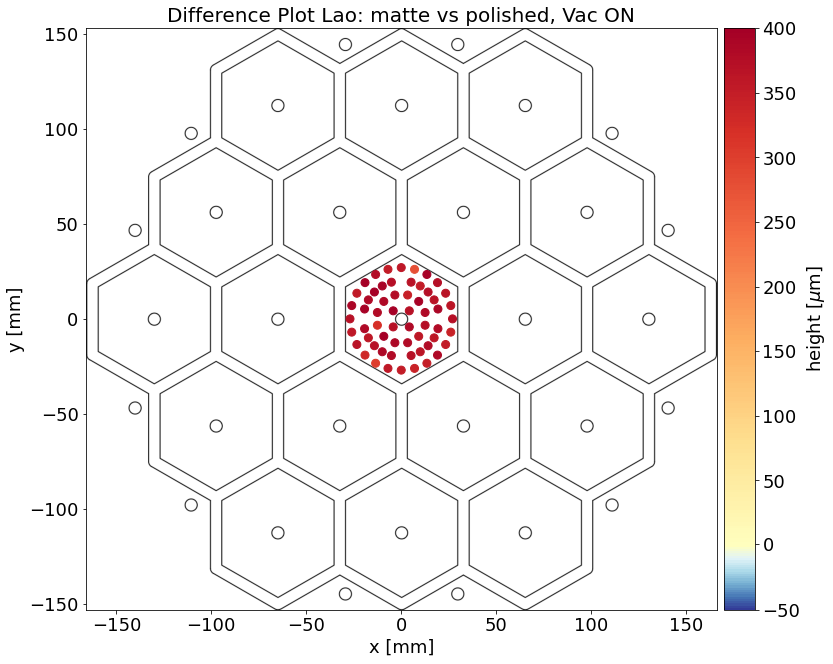

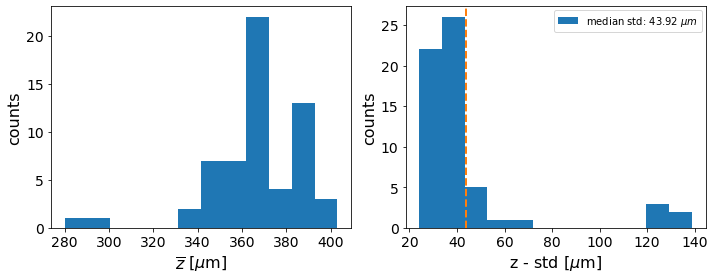

In [25]:
%matplotlib inline
matte = one_tile_scans_pt['070921_1Tile_LAO_Vac_matt.txt']
polished = one_tile_scans_pt['070921_1Tile_LAO_Vac_pol.txt']

diff_mat_pol = matte - polished

diff_mat_pol['x', 'mean'] = matte['x', 'mean']
diff_mat_pol['y', 'mean'] = matte['y', 'mean']
diff_mat_pol['z', 'std'] = np.sqrt(np.add(np.power(matte['z', 'std'],2),np.power(polished['z', 'std'],2)))

fig, ax = full_hexagon_plot(diff_mat_pol, mode=('z', 'mean'),size=8**2, cbar_max=400, cbar_min=-50)
ax.set_title('Difference Plot Lao: matte vs polished, Vac ON', fontsize=20)
z_value_hist(diff_mat_pol)

## Steel 1 Tile

In [26]:
one_tile_scans_path = Path('.') / 'one_tile_scan'
one_tile_files = next(walk(one_tile_scans_path), (None, None, []))[2]  # [] if no file
one_tile_steel = {file: read_measurement(one_tile_scans_path/file) for file in one_tile_files if file.startswith('090921')}
one_tile_steel_data = {key: point_table(data) for key,data in one_tile_steel.items()}


(<Figure size 720x288 with 2 Axes>,
 (<AxesSubplot:xlabel='$\\overline{z}$ [$\\mu$m]', ylabel='counts'>,
  <AxesSubplot:xlabel='z - std [$\\mu$m]', ylabel='counts'>))

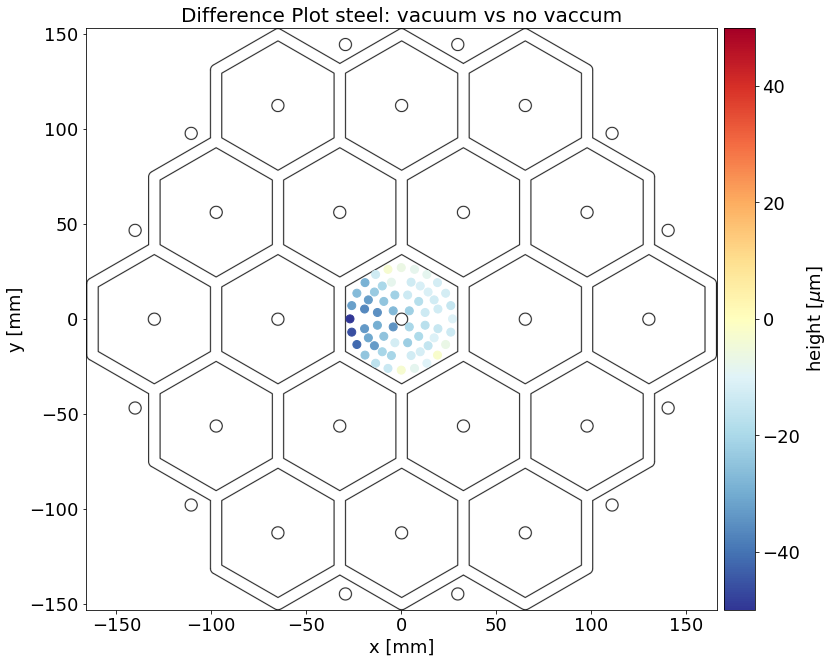

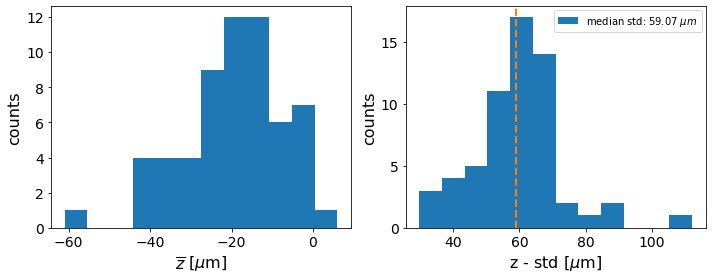

In [27]:
%matplotlib inline
steel_vac = one_tile_steel_data['090921_1Tile_Steel_Vac.txt']
steel_no_vac = one_tile_steel_data['090921_1Tile_Steel_noVac.txt']

steel_diff_vac_novac = steel_vac - steel_no_vac

steel_diff_vac_novac['x', 'mean'] = steel_vac['x', 'mean']
steel_diff_vac_novac['y', 'mean'] = steel_vac['y', 'mean']
steel_diff_vac_novac['z', 'std'] = np.sqrt(np.add(np.power(steel_vac['z', 'std'],2),np.power(steel_no_vac['z', 'std'],2)))

fig, ax = full_hexagon_plot(steel_diff_vac_novac, mode=('z', 'mean'),size=8**2, cbar_max=50, cbar_min=-50)
ax.set_title('Difference Plot steel: vacuum vs no vaccum', fontsize=20)
z_value_hist(steel_diff_vac_novac)

In [28]:
import statsmodels.formula.api as sm 
from sklearn.preprocessing import PolynomialFeatures

from matplotlib.colors import TwoSlopeNorm

xy_vec = [[x,y] for (x,y) in zip(steel_diff_vac_novac['x', 'mean'], steel_diff_vac_novac['y', 'mean'])]
xy_vec = np.array(xy_vec)
z_vec = np.array(steel_diff_vac_novac['z', 'median'])
#* Quadratic regression!
xy_vec_ = PolynomialFeatures(degree=2, include_bias=True).fit_transform(xy_vec)


model = LinearRegression().fit(xy_vec_, z_vec)
r_sq = model.score(xy_vec_,z_vec)
z_0 = model.intercept_
slope = model.coef_
F = r_sq/2 * len(one_tile_ref['z', 'median'])
z_pred = model.predict(xy_vec_)

def my_chi_square(obs, expected, error):
    chi_sq = np.sum(np.divide(np.square(np.subtract(obs, expected)), error**2))
    return chi_sq

chi_sq = my_chi_square(steel_diff_vac_novac['z', 'median'], np.asarray(z_pred), steel_diff_vac_novac['z', 'std']) / 3

model_params = {'r_sq': r_sq, 'z_0': z_0, 'slope': slope, 'F': F, 'chi_sq': chi_sq}
for key, val in model_params.items():
    print(f'{key} = {val}')
#* Plot surface + points 
%matplotlib
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.hold(True)
xx, yy = np.meshgrid(steel_diff_vac_novac['x', 'mean'], steel_diff_vac_novac['y', 'mean'])
cbar_max = 15
cbar_min = -30
colornorm = TwoSlopeNorm(vcenter=0, vmax=cbar_max, vmin=cbar_min) 
surface = ax.plot_trisurf(steel_diff_vac_novac['x', 'mean'], steel_diff_vac_novac['y', 'mean'], z_pred*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar = fig.colorbar(surface)
ax.scatter(steel_diff_vac_novac['x', 'mean'], steel_diff_vac_novac['y', 'mean'], steel_diff_vac_novac['z', 'median']*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar.ax.tick_params(labelsize=16)
c_bar.ax.set_ylabel("height [$\mu$m]", fontsize=16)
ax.set_xlabel("x [mm]", fontsize=16)
ax.set_ylabel("y [mm]", fontsize=16)
ax.set_zlabel("z [$\mu$m]", fontsize=16)
ax.tick_params(labelsize=16)

r_sq = 0.6332602036547219
z_0 = -0.02229083256323802
slope = [ 0.00000000e+00  5.82597454e-04 -5.53982426e-05 -7.05074789e-06
 -5.67649966e-06  2.28423594e-05]
F = 18.997806109641658
chi_sq = 0.362513210596579
Using matplotlib backend: Qt5Agg


In [29]:
import statsmodels.formula.api as sm 
from sklearn.preprocessing import PolynomialFeatures

from matplotlib.colors import TwoSlopeNorm

xy_vec = [[x,y] for (x,y) in zip(steel_diff_vac_novac['x', 'mean'], steel_diff_vac_novac['y', 'mean'])]
xy_vec = np.array(xy_vec)
z_vec = np.array(steel_diff_vac_novac['z', 'median'])
#* Quadratic regression!
# xy_vec_ = PolynomialFeatures(degree=2, include_bias=True).fit_transform(xy_vec)
xy_vec_ = xy_vec

model = LinearRegression().fit(xy_vec_, z_vec)
r_sq = model.score(xy_vec_,z_vec)
z_0 = model.intercept_
slope = model.coef_
F = r_sq/2 * len(one_tile_ref['z', 'median'])
z_pred = model.predict(xy_vec_)

def my_chi_square(obs, expected, error):
    chi_sq = np.sum(np.divide(np.square(np.subtract(obs, expected)), error**2))
    return chi_sq

chi_sq = my_chi_square(steel_diff_vac_novac['z', 'median'], np.asarray(z_pred), steel_diff_vac_novac['z', 'std']) / 3

model_params = {'r_sq': r_sq, 'z_0': z_0, 'slope': slope, 'F': F, 'chi_sq': chi_sq}
for key, val in model_params.items():
    print(f'{key} = {val}')
#* Plot surface + points 
%matplotlib
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.hold(True)
xx, yy = np.meshgrid(steel_diff_vac_novac['x', 'mean'], steel_diff_vac_novac['y', 'mean'])
cbar_max = 15
cbar_min = -30
colornorm = TwoSlopeNorm(vcenter=0, vmax=cbar_max, vmin=cbar_min) 
surface = ax.plot_trisurf(steel_diff_vac_novac['x', 'mean'], steel_diff_vac_novac['y', 'mean'], z_pred*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar = fig.colorbar(surface)
ax.scatter(steel_diff_vac_novac['x', 'mean'], steel_diff_vac_novac['y', 'mean'], steel_diff_vac_novac['z', 'median']*1e3, cmap="RdYlBu_r", norm=colornorm)
c_bar.ax.tick_params(labelsize=16)
c_bar.ax.set_ylabel("height [$\mu$m]", fontsize=16)
ax.set_xlabel("x [mm]", fontsize=16)
ax.set_ylabel("y [mm]", fontsize=16)
ax.set_zlabel("z [$\mu$m]", fontsize=16)
ax.tick_params(labelsize=16)

r_sq = 0.4427945394589936
z_0 = -0.018650000000002366
slope = [ 5.82597454e-04 -5.53982426e-05]
F = 13.283836183769807
chi_sq = 0.5598458335795607
Using matplotlib backend: Qt5Agg


# Full Disk Steel Scan

In [30]:
full_disk_steel_path = Path('.') / 'SteelScan_Test1'
full_disk_steel_file = next(walk(full_disk_steel_path), (None, None, []))[2]  # [] if no file
full_disk_steel_pt = {file: read_measurement(full_disk_steel_path / file) for file in full_disk_steel_file}
full_disk_steel_df = point_table(full_disk_steel_pt['130921_SteelScan_Mplaced_Vac_SpotsUp.txt'])


(<Figure size 720x288 with 2 Axes>,
 (<AxesSubplot:xlabel='$\\overline{z}$ [$\\mu$m]', ylabel='counts'>,
  <AxesSubplot:xlabel='z - std [$\\mu$m]', ylabel='counts'>))

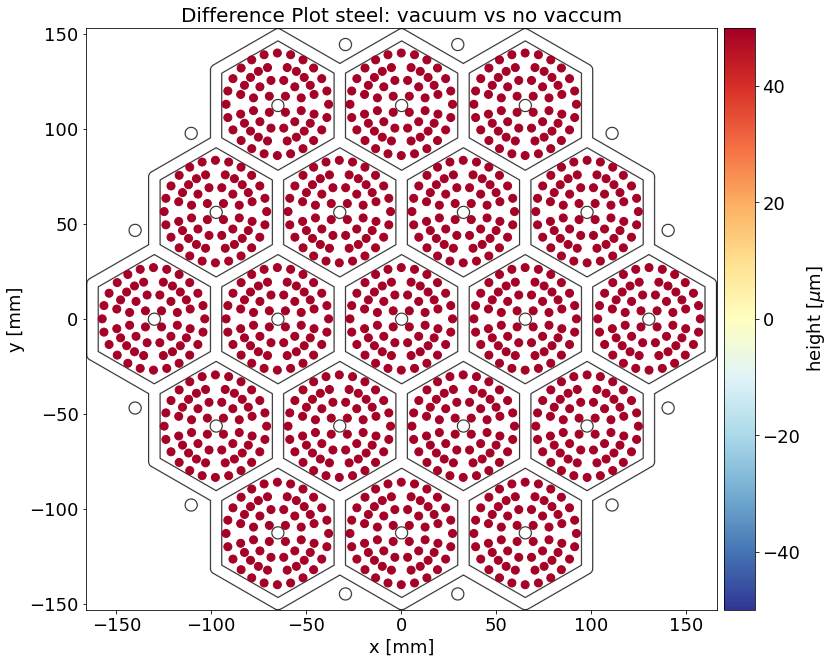

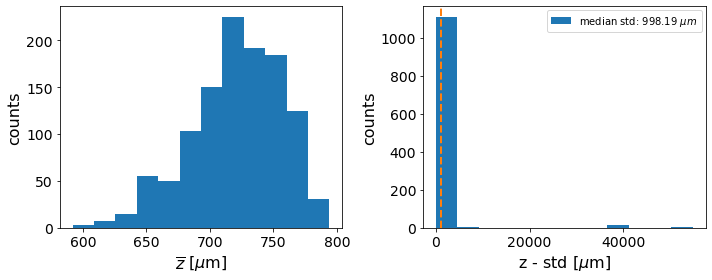

In [31]:
%matplotlib inline
fig, ax = full_hexagon_plot(full_disk_steel_df, mode=('z', 'median'),size=8**2, cbar_max=50, cbar_min=-50)
ax.set_title('Difference Plot steel: vacuum vs no vaccum', fontsize=20)
# plt.close()
z_value_hist(full_disk_steel_df)
# plt.close()